# Baseline-решение

## Импорт библиотек, загрузка данных

In [138]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

In [90]:
TRAIN = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_train.csv"
TEST = "https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/chocolate_test_new.csv"

In [91]:
train_df = pd.read_csv(TRAIN)

## Обзор данных, подготовка к обучению

In [50]:
train_df.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia


Преобразуем строковую фичу Cocoa Percent в float

In [92]:
train_df['Cocoa Percent'] = train_df['Cocoa Percent'].apply(lambda x: float(x.split('%')[0]))
train_df['Cocoa Percent']

0       72.0
1       72.0
2       70.0
3       72.0
4       75.0
        ... 
1250    80.0
1251    70.0
1252    68.0
1253    72.0
1254    70.0
Name: Cocoa Percent, Length: 1255, dtype: float64

Выделим категориальные и числовые признаки отдельно

In [93]:
num_features = train_df.select_dtypes(include='number')
cat_features = train_df.select_dtypes(include='object')

Проверим пропуски

In [113]:
num_features.isna().sum(), cat_features.isna().sum()

(REF              0
 Review           0
 Cocoa Percent    0
 Rating           0
 dtype: int64,
 Company                 0
 Specific Bean Origin    0
 Company Location        0
 Bean Type               0
 Broad Bean Origin       0
 dtype: int64)

In [117]:
train_df.fillna('', inplace=True)

In [118]:
train_df.isnull().sum()

Company                 0
Specific Bean Origin    0
Review                  0
Cocoa Percent           0
Company Location        0
Rating                  0
Bean Type               0
Broad Bean Origin       0
dtype: int64

Посмотрим на корреляцию числовых признаков

In [96]:
num_features.corr()

,REF,Review,Cocoa Percent,Rating
REF,1.000000,0.984938,0.045015,0.112792
Review,0.984938,1.000000,0.045322,0.111826
Cocoa Percent,0.045015,0.045322,1.000000,-0.172411
Rating,0.112792,0.111826,-0.172411,1.000000


У REF и Review высокая положительная корреляция, что в целом логично, удалим REF

In [97]:
train_df.drop(columns=['REF'], inplace=True)

Посмотрим на статистики фичей

In [98]:
train_df.describe(include='object')

,Company,Specific Bean Origin,Company Location,Bean Type,Broad Bean Origin
count,1255,1255,1255,1254,1254
unique,376,762,58,38,84
top,Soma,Madagascar,U.S.A.,,Venezuela
freq,35,39,521,628,144


In [99]:
train_df.describe(exclude='object')

,Review,Cocoa Percent,Rating
count,1255.000000,1255.000000,1255.000000
mean,2012.382470,71.790438,3.176494
std,2.922499,6.397448,0.478948
min,2006.000000,46.000000,1.000000
25%,2010.000000,70.000000,2.750000
50%,2013.000000,70.000000,3.250000
75%,2015.000000,75.000000,3.500000
max,2017.000000,100.000000,5.000000


Выделяем матрицу объект-признак и вектор с целевой переменной

In [119]:
X_train = train_df.drop('Rating', axis=1)
y_train = train_df['Rating']

(array([  3.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   7.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,
          0.,   0.,   0.,  23.,   0.,   0.,   0.,   0.,   0.,   9.,   0.,
          0.,   0.,   0.,   0.,  87.,   0.,   0.,   0.,   0.,   0., 198.,
          0.,   0.,   0.,   0.,   0.,   0., 234.,   0.,   0.,   0.,   0.,
          0., 217.,   0.,   0.,   0.,   0.,   0., 265.,   0.,   0.,   0.,
          0.,   0., 142.,   0.,   0.,   0.,   0.,   0.,   0.,  66.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          2.]),
 array([1.  , 1.04, 1.08, 1.12, 1.16, 1.2 , 1.24, 1.28, 1.32, 1.36, 1.4 ,
        1.44, 1.48, 1.52, 1.56, 1.6 , 1.64, 1.68, 1.72, 1.76, 1.8 , 1.84,
        1.88, 1.92, 1.96, 2.  , 2.04, 2.08, 2.12, 2.16, 2.2 , 2.24, 2.28,
        2.32, 2.36, 2.4 , 2.44, 2.48, 2.52, 2.56, 2.6 , 2.64, 2.68, 2.72,
        2.76, 2.8 , 2.

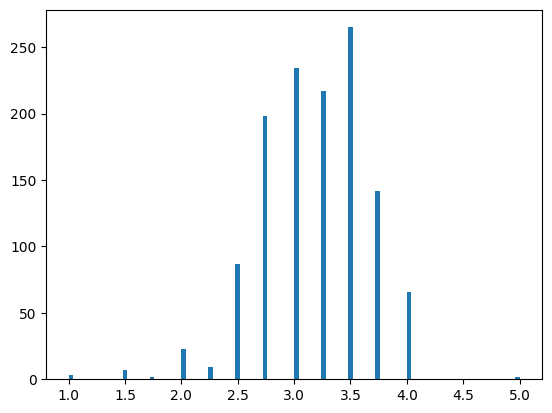

In [120]:
from matplotlib import pyplot as plt

plt.hist(y_train, bins=100)

In [164]:
y_train = np.log(y_train)

## Обучение модели

Устанавливаем катбуст и обучаем его с гиперпараметрами по умолчанию на всех данных

In [102]:
!pip install catboost -q


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [103]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1255 non-null   object 
 1   Specific Bean Origin  1255 non-null   object 
 2   Review                1255 non-null   int64  
 3   Cocoa Percent         1255 non-null   float64
 4   Company Location      1255 non-null   object 
 5   Bean Type             1254 non-null   object 
 6   Broad Bean Origin     1254 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 68.8+ KB


In [388]:
cat_features_indexes = [0, 1, 4, 5, 6]

In [175]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(cat_features=cat_features_indexes)
cross_val_score(model, X_train, y_train, cv=5, scoring='r2').mean()

Learning rate set to 0.040969
0:	learn: 0.1694387	total: 22.1ms	remaining: 22.1s
1:	learn: 0.1686779	total: 47.2ms	remaining: 23.6s
2:	learn: 0.1679300	total: 69.4ms	remaining: 23.1s
3:	learn: 0.1673740	total: 93.2ms	remaining: 23.2s
4:	learn: 0.1666945	total: 127ms	remaining: 25.2s
5:	learn: 0.1661319	total: 150ms	remaining: 24.8s
6:	learn: 0.1654424	total: 174ms	remaining: 24.7s
7:	learn: 0.1648267	total: 198ms	remaining: 24.5s
8:	learn: 0.1641275	total: 223ms	remaining: 24.5s
9:	learn: 0.1635890	total: 257ms	remaining: 25.4s
10:	learn: 0.1627362	total: 301ms	remaining: 27.1s
11:	learn: 0.1619163	total: 346ms	remaining: 28.5s
12:	learn: 0.1614536	total: 380ms	remaining: 28.9s
13:	learn: 0.1605719	total: 426ms	remaining: 30s
14:	learn: 0.1598344	total: 447ms	remaining: 29.3s
15:	learn: 0.1589780	total: 475ms	remaining: 29.2s
16:	learn: 0.1584606	total: 498ms	remaining: 28.8s
17:	learn: 0.1579775	total: 520ms	remaining: 28.4s
18:	learn: 0.1573455	total: 540ms	remaining: 27.9s
19:	learn

0.22049899877991974

Попробуем обучить другие модели

In [141]:
!pip install category_encoders -q


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [143]:
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder

In [389]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge

preprocessor = Pipeline([
    ('encoder', LeaveOneOutEncoder(cols=cat_features.columns.tolist())),
    ('poly', PolynomialFeatures(interaction_only=True, include_bias=False)),
    ('scaler', StandardScaler())
])

model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Ridge())
])

param_grid = {
    'preprocessor__encoder__sigma': [0.0, 0.1, 0.5, 1.0],
    'preprocessor__poly__degree': [1, 2, 3],
    'model__alpha': [0.1, 1.0, 10.0, 100.0]
}

ridge = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
ridge.fit(X_train, y_train)

print("Лучшие параметры:", ridge.best_params_)
print("Лучший R2:", ridge.best_score_)

Лучшие параметры: {'model__alpha': 1.0, 'preprocessor__encoder__sigma': 0.0, 'preprocessor__poly__degree': 2}
Лучший R2: 0.13075511449760685


In [362]:
from sklearn.ensemble import RandomForestRegressor

preprocessor = Pipeline([
    ('encoder', LeaveOneOutEncoder(cols=cat_features.columns.tolist())),
    ('poly', PolynomialFeatures(interaction_only=True, include_bias=False)),
    ('scaler', StandardScaler())
])

random_forest_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

rf_param_grid = {
    'preprocessor__encoder__sigma': [0.0, 0.1, 0.5, 1.0],
    'preprocessor__poly__degree': [1, 2, 3],
    'model__n_estimators': [100, 200, 500],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(
    estimator=random_forest_pipeline,
    param_grid=rf_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)

print("Лучшие параметры:", rf_grid.best_params_)
print("Лучший R2:", rf_grid.best_score_)

C:\Users\Gulfik\Desktop\petprojects\hseContest\.venv\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Лучшие параметры: {'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 100, 'preprocessor__encoder__sigma': 0.1, 'preprocessor__poly__degree': 3}
Лучший R2: 0.17676057553005053


In [390]:
param_grid = {
    'iterations': [800, 900, 1000, 1100],
    'depth': [3, 4, 5, 6],
    'learning_rate': [0.02, 0.03, 0.04],
    'l2_leaf_reg': [3, 4, 5],
    'bagging_temperature': [0.4, 0.5, 0.6],
    'subsample': [0.8, 0.9]
}

model = CatBoostRegressor(cat_features=cat_features_indexes, silent=True, random_state=42)

catboost = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

catboost.fit(X_train, y_train)

print("Лучшие параметры:", catboost.best_params_)
print("Лучший R2:", catboost.best_score_)

C:\Users\Gulfik\Desktop\petprojects\hseContest\.venv\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Лучшие параметры: {'bagging_temperature': 0.4, 'depth': 4, 'iterations': 1000, 'l2_leaf_reg': 3, 'learning_rate': 0.03, 'subsample': 0.9}
Лучший R2: 0.2548386295318055


In [391]:
from sklearn.ensemble import StackingRegressor

base_models = [
    ('ridge', ridge.best_estimator_),
    ('random_forest', rf_grid.best_estimator_),
    ('catboost', catboost.best_estimator_),
]

final_model = Ridge(alpha=1.0)

stacking_model = StackingRegressor(estimators=base_models, final_estimator=final_model, cv=5, n_jobs=-1)

cross_val_score(stacking_model, X_train, y_train, cv=5, scoring='r2').mean()

0.2507609571379348

## Предсказание на тестовых данных

Загружаем тестовые данные

In [432]:
test_df = pd.read_csv(TEST)

In [433]:
test_df.drop(columns=['REF'], inplace=True)

In [434]:
test_df['Cocoa Percent'] = test_df['Cocoa Percent'].apply(lambda x: float(x.split('%')[0]))

In [435]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               540 non-null    object 
 1   Specific Bean Origin  540 non-null    object 
 2   Review                540 non-null    int64  
 3   Cocoa Percent         540 non-null    float64
 4   Company Location      540 non-null    object 
 5   Bean Type             540 non-null    object 
 6   Broad Bean Origin     540 non-null    object 
dtypes: float64(1), int64(1), object(5)
memory usage: 29.7+ KB


Делаем предсказание

In [436]:
residuals = y_train - catboost.best_estimator_.predict(X_train)
plt.hist(residuals, bins=30)
plt.title("Residual Analysis")
plt.show()


AttributeError: 'StackingRegressor' object has no attribute 'best_estimator_'

In [425]:
import numpy as np
outliers = np.abs(residuals) > 2 * residuals.std()  # Остатки больше 1.9 сигм
X_train_cleaned = X_train[~outliers]
y_train_cleaned = y_train[~outliers]

In [426]:
catboost.best_estimator_.fit(X_train_cleaned, y_train_cleaned)
pred = np.exp(stacking_modelпр.predict(test_df))

Сохраняем предсказание в файл в нужном формате

In [427]:
test_df['id'] = np.arange(len(test_df))
test_df['Rating'] = pred

test_df[['id', 'Rating']].to_csv("baseline_submission.csv", index=False)